In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools

## Having a look at the data

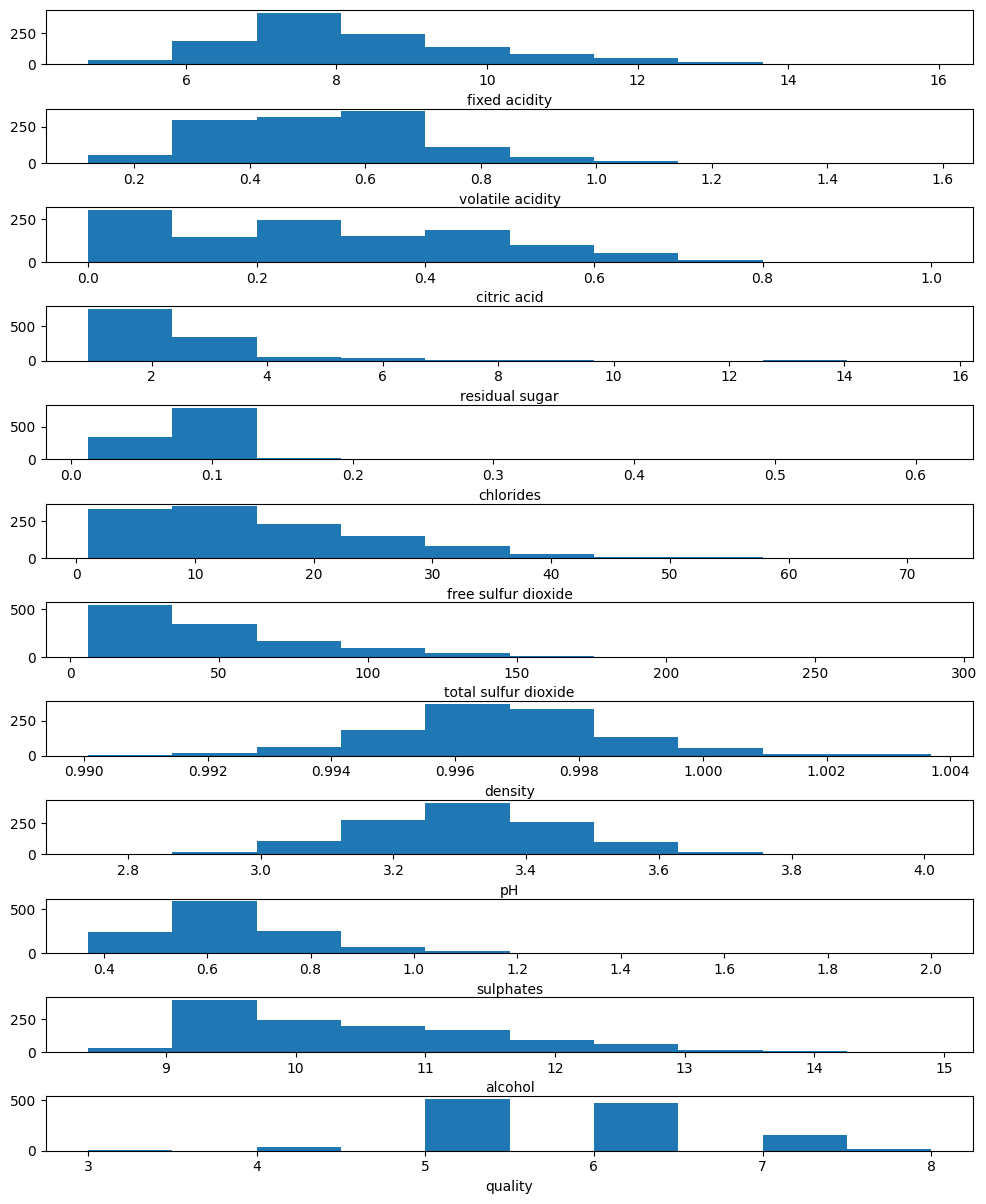

In [2]:
dataset = pd.read_csv('trainset.csv')
_,ax = plt.subplots(nrows=len(dataset.columns), ncols=1, figsize=(10,12))
plt.tight_layout()
for i,column in enumerate(dataset.columns):
    ax[i].hist(dataset[column])
    ax[i].set_xlabel(column) # I'll start by considering quality as a continuous variable with no further changes
data = dataset.to_numpy()

## Learning a linear gaussian bayes net with a given adjacency matrix

A linear gaussian bayes net describes a gaussian probability distribution. Each node in such a network itself represents a gaussian distribution over one attribute/variable. Edges between nodes signify dependence of one variable on the other. ($A \rightarrow B$ means $A$ influences $B$, $B$ is dependent on $A$)

For each node $x_i$ , we define its conditional probability distribution:
$$
p(x_i | \text{parents}(i)) = \mathcal{N}\left( \beta_{i0} + \sum_{i \in \text{parents}(j)} \beta_{ij} x_j, \sigma_i \right)
$$
with parameters:
- $\beta_{ij}$: coefficients describing the way $x_j$ influences $x_i$
- $\beta_{i0}$: offset 
- $\sigma_i$: conditional variance of $x_i$ (conditioned on $\text{parents}(i)$)

We compute the coefficients and offset by fitting a linear regression, and compute the conditional variance using a formula derived from its definition:
$$
\text{Var}[Y|X] = E \left[(Y - E[Y|X])^2 \right] \\
\text{sampleVar}(y|x) = \frac{1}{m-1} \sum_{i=1}^m (y_i - \hat{y}_x)^2
$$
where:
- $y_i$ is the value of this attribute for each datapoint
- $\hat{y}_x$ is the predicted value of $y_i$ given the values of the other attributes $x$ 

In [120]:
from typing import Dict, Union
from sklearn.linear_model import LinearRegression

@dataclass
class StaticParam:
    mu: float
    sigma: float

@dataclass
class DependentParam:
    coefficients: np.ndarray
    offset: np.ndarray
    sigma: float

Param = Union[StaticParam, DependentParam] # A param is either static or dependent

class GaussNet1():
    def __init__(self, adj: np.ndarray):
        self.adj = adj
        self.n = adj.shape[0]  # number of variables
        self.params: Dict[int, Param] = {}  # parameters defining gaussian distribution for each variable

    def parents(self, node_idx):
        return np.argwhere(self.adj[:,node_idx] == 1).flatten().tolist() # returns the indices of the parents of the node
        
    def fit(self, data: np.ndarray):
        def compute_static_params():
            target_data = data[:, node_idx]
            mu = np.mean(target_data)
            sigma = np.var(target_data)
            return StaticParam(mu, sigma)
            
        def compute_dependent_params():
            target_data = data[:, node_idx]
            predictor_data = data[:, self.parents(node_idx)]
            reg = LinearRegression().fit(predictor_data, target_data) # fit a linear regression
            coefficients = reg.coef_
            offset = reg.intercept_
            predicted_data = reg.predict(predictor_data)
            sigma = (1/(m-1)) * np.sum((target_data - predicted_data)**2)
            return DependentParam(coefficients, offset, sigma)
        
        m = data.shape[0]
        for node_idx in range(self.n):
            if self.parents(node_idx) == []:  # No parents
                self.params[node_idx] = compute_static_params()
            else:
                self.params[node_idx] = compute_dependent_params()
    def predict(self, data: np.ndarray, node_idx: int, toround=False):
        predictors = data[:, self.parents(node_idx)]
        param = self.params[node_idx]
        if type(param) == StaticParam:
            if toround:
                return np.around(param.mu)
            else:
                return param.mu
        else:
            if toround:
                return np.around(param.offset + predictors @ param.coefficients)
            else:
                return param.offset + predictors @ param.coefficients

    def accuracy(self, data: np.ndarray, node_idx: int): # Assumes that node_idx is a categorical variable obtained by rounding the estimate
        predicted = self.predict(data, node_idx, toround=True)
        return np.count_nonzero(predicted == data[:,node_idx]) / predicted.shape[0]

In [121]:
num_attributes = data.shape[1]
test_adj = np.zeros((num_attributes, num_attributes))
test_adj[10,11] = 1 # let's say that residual sugar predicts quality
net1 = GaussNet1(test_adj)
net1.fit(data)
net1.params[11]

DependentParam(coefficients=array([0.35419866]), offset=1.9564383703769535, sigma=0.5232316131752069)

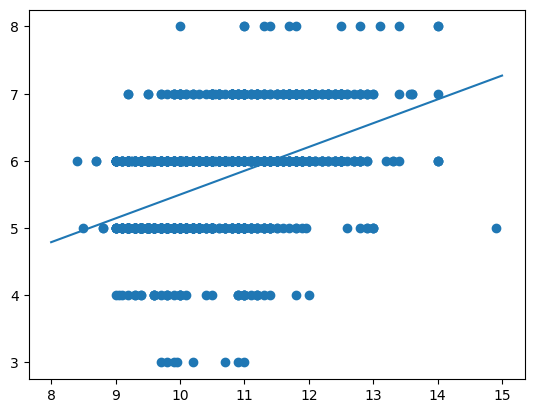

In [122]:
plt.scatter(data[:,10], data[:,11])
plt.plot([8,15], [net1.params[11].offset + net1.params[11].coefficients[0]*8, net1.params[11].offset + net1.params[11].coefficients[0]*15])

## Second try for gauss nets

In [156]:
from typing import Dict, Union
from dataclasses import dataclass

# if there are any parents, mu and sigma are computed using
# coefficients and offset, but if there are no parents, they are static
@dataclass
class StaticParam:
    mu: float
    sigma: float

@dataclass
class DependentParam:
    coefficients: np.ndarray
    offset: np.ndarray
    sigma: float

Param = Union[StaticParam, DependentParam] # A param is either static or dependent

def myindex(arr, idx_I, idx_J=[]): # Leaves only the indices idx_I and idx_J in array arr
    if arr.ndim > 2: return arr
    if arr.ndim == 1: return arr[idx_I]
    if arr.ndim == 2: return np.atleast_2d(arr[idx_I,:])[:,idx_J]

class GaussNet2():
    def __init__(self, adj: np.ndarray):
        self.adj = adj
        self.n = adj.shape[0]  # number of variables
        self.params: Dict[int, Param] = {}  # parameters defining gaussian distribution for each variable

    def parents(self, node_idx):
        return np.argwhere(self.adj[:,node_idx] == 1).flatten().tolist() # returns the indices of the parents of the node

    def fit(self, data: np.ndarray):
        def compute_static_params() -> StaticParam:
            target_data = data[:, node_idx]
            mu = np.mean(target_data)
            sigma = np.var(target_data)
            return StaticParam(mu, sigma)
        def compute_dependent_params() -> DependentParam:
            target_data = data[:, node_idx]
            parents = self.parents(node_idx)
            mu_I = np.mean(target_data)
            sigma_full = np.cov(data, rowvar=False)
            sigma_IJ = myindex(sigma_full, node_idx, parents)
            sigma_JJ = myindex(sigma_full, parents, parents)
            mu_J = np.mean(data[:,parents], axis=0)
            sigma_II = myindex(sigma_full, node_idx, node_idx)
            sigma_JI = myindex(sigma_full, parents, node_idx)
            
            offset = mu_I - sigma_IJ @ np.linalg.inv(sigma_JJ) @ np.atleast_2d(mu_J).T
            coefficients = sigma_IJ @ np.linalg.inv(sigma_JJ)
            sigma = sigma_II - coefficients @ sigma_JI
            return DependentParam(coefficients, offset, sigma)
        for node_idx in range(self.n):
            if self.parents(node_idx) == []:  # No parents
                self.params[node_idx] = compute_static_params()
            else:
                self.params[node_idx] = compute_dependent_params()

    def predict(self, data: np.ndarray, node_idx: int, toround=False):
        predictors = data[:, self.parents(node_idx)]
        param = self.params[node_idx]
        if type(param) == StaticParam:
            if toround:
                return np.around(param.mu)
            else:
                return param.mu
        else:
            if toround:
                return np.around(param.offset + predictors @ param.coefficients)
            else:
                return param.offset + predictors @ param.coefficients
    
    def accuracy(self, data: np.ndarray, node_idx: int): # Assumes that node_idx is a categorical variable obtained by rounding the estimate
        predicted = np.squeeze(self.predict(data, node_idx, toround=True))
        return np.count_nonzero(predicted == data[:,node_idx]) / predicted.shape[0]

In [157]:
num_attributes = data.shape[1]
test_adj = np.zeros((num_attributes, num_attributes))
test_adj[10,11] = 1 # let's say that residual sugar predicts quality
net2 = GaussNet2(test_adj)
net2.fit(data)
net2.params[11]
np.save('submission.npy', test_adj)

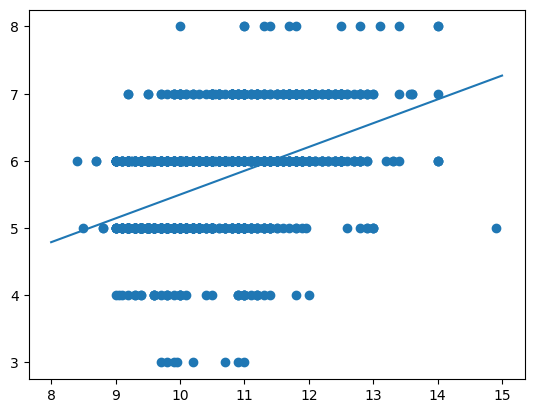

In [158]:
plt.scatter(data[:,10], data[:,11])
plt.plot([8,15], [net2.params[11].offset[0][0] + net2.params[11].coefficients[0][0]*8, net2.params[11].offset[0][0] + net2.params[11].coefficients[0][0]*15])

In [159]:
print(net1.accuracy(data, 11))
print(net2.accuracy(data, 11))

0.5504587155963303
0.5504587155963303


#### They're equivalent!